In [87]:
import xrfclk
import xrfdc
xrfclk.set_ref_clks(245.76)

In [88]:
from pynq import Overlay
ol = Overlay("/home/xilinx/overlays/zcu216_nmcp/zcu216_nmcp88.bit")
ol?

In [89]:
rf = ol.usp_rf_data_converter_0
#rf.IPStatus

In [90]:
tile2 = rf.dac_tiles[2]
#tile2.PLLConfig
tile2.SetupFIFO(True)

In [91]:
dac_block = tile2.blocks[0]
#dac_block.BlockStatus
#dac_block.MixerSettings

In [92]:
fifo = ol.axi_fifo_mm_s_0

In [93]:
#fifo.register_map
ISR = 0x00
IER = 0x04
TDFV = 0x0C
TDFD = 0x10
TLR = 0x14
TDR = 0x2C
numwords = fifo.read(TDVC)
hex(numwords)

'0x1ffc'

'0xd2d'

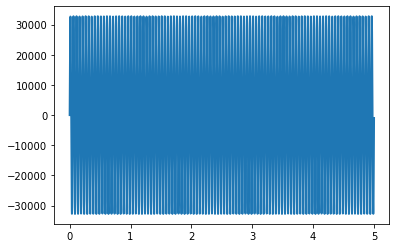

In [94]:
import numpy as np
import matplotlib.pylab as plt

A = 1       # Amplitude
f = 20      # Desired frequency 
t = 5       # Time
fs = 674.432 # Sampling rate

# Define 'continuous' signal for comparison
x = np.arange(0, t, 1/fs)            
y = A * np.sin(2 * np.pi * f * x)

#plt.plot(x, y, linewidth = 2)
#hex(y.size)

y_real = np.multiply(np.real(y), np.power(2, 15)).astype(np.int32)
plt.plot(x, y_real, linewidth = 2)
hex(y_real.size)

In [95]:
# ------------------------------------------------------------------

In [98]:
tile2.SetupFIFO(True)
while(1<2):
#for j in range(100):
    hex(fifo.read(ISR)) # read ISR
    fifo.write(ISR, 0xffffffff) # reset interrupts
    hex(fifo.read(ISR)) # check ISR, should be zeros
    hex(fifo.read(IER)) # read IER
    hex(fifo.read(TDFV)) # check vacancy
    fifo.write(IER, 0x0C000000) # write to IER, should "Enable transmit complete and receive complete interrupts"
    fifo.write(TDR, 0x00000002) # write destination address
    
    # write data to TDFD
    txsize = y_real.size
    for i in range(txsize):
        fifo.write(TDFD, y_real[i].item())
        
    hex(fifo.read(TDFV)) # check vacancy
    fifo.write(TLR, txsize * 4) # write to TLR, this should start the transfer and empty the FIFO
    hex(fifo.read(ISR)) # read ISR
    fifo.write(ISR, 0xffffffff) # reset interrupts
    hex(fifo.read(TDFV)) # check vacancy again

KeyboardInterrupt: 